## CNN for pixel-wise ship detection

CNN model from the article: [Ship Identification and Characterization in Sentinel-1 SAR Images with Multi-Task Deep Learning](https://doi.org/10.3390/rs11242997)

Dataset can be aqcuired [here:](https://gitlab.com/sarmaps/sar-ship-dataset), and the pre-processing description [here:](https://sci-hub.ren/10.1109/igarss.2016.7729017)


In [57]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append(r'C:\Users\arman\Documents\GitHub\sar_ship_detect\scripts')
from utils import data_split, lee_filter, im_resize, data_extractor_from_df, bbox_draw
from cfar import CA_CFAR

In [2]:
PATH = r'C:\Users\arman\Documents\GitHub\sar_ship_detect'
#data_path = join(os. getcwd(), '..','data', 'Iceberg-classifier-challenge')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [3]:
os.listdir(data_path)

['false_positives.json', 'ship_positives.json', 'true_negatives.json']

###### As we carry a pixel-wise classification, we will pick up only the dataset containing ships `(ship_positives)`.

In [4]:
#Load the data.
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
print('true_positives: ',ship_positives.shape)

true_positives:  (1, 1596)


In [5]:
# the following information is provided for each of the ship data
ship_positives[0][0].keys()

dict_keys(['id', 'sensor', 'resolution', 'fullname', 'polarisation', 'incidenceangle', 'row', 'column', 'longitude', 'latitude', 'stats', 'R', 'nearest', 'pixelsize', 'patchfu', 'patchgt', 'windowfu', 'windowgt', 'validais', 'ais', 'aux'])

## Data Pre-processing

In [6]:
# dsize = (101, 101)

# get true positive data
ship_positive_data = data_extractor_from_df(ship_positives, 'patchfu')
# get the pixel based classes 
ship_positive_target = data_extractor_from_df(ship_positives, 'patchgt')

In [9]:
# renam the variables for the sake of ease
data = ship_positive_data
target = ship_positive_target

In [10]:
print('Data shape:\t', data.shape)
print('Target shape:\t',target.shape)

Data shape:	 (1596, 101, 101)
Target shape:	 (1596, 101, 101)


### Data visualization

Text(0.5, 1.0, 'radar data')

<Figure size 432x288 with 0 Axes>

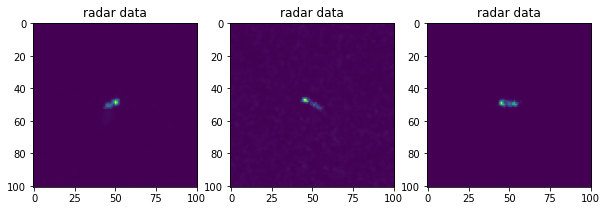

In [12]:
# visualize image samples 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

# use the created array to output your multiple images. 
axarr[0].imshow(data[1200,:,:])
axarr[0].set_title('radar data')
axarr[1].imshow(data[14,:,:])  
axarr[1].set_title('radar data')
axarr[2].imshow(data[43,:,:])
axarr[2].set_title('radar data')

Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

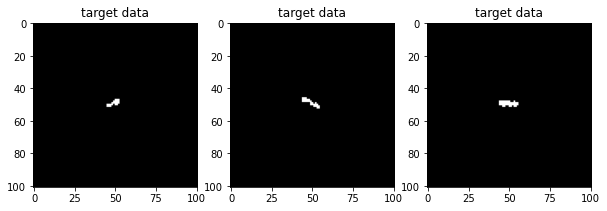

In [11]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(target[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(target[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(target[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Run CA-CFAR analysis

In [42]:
# Define parameters for CFAR
params = [10, 10, 1, 1]
P_fa = 10e-4

detedt_cfar = np.array([CA_CFAR(image, params, P_fa) for image in data])

In [52]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
labels = np.array(['not ship 0', 'ship 1'])

print()
print(classification_report(target.reshape(1596*101*101, 1), detedt_cfar.reshape(1596*101*101, 1), target_names=labels))
print('Confusion matrix \n', confusion_matrix(target.reshape(1596*101*101, 1), detedt_cfar.reshape(1596*101*101, 1)))


              precision    recall  f1-score   support

  not ship 0       1.00      1.00      1.00  16255900
      ship 1       0.26      0.83      0.40     24896

    accuracy                           1.00  16280796
   macro avg       0.63      0.91      0.70  16280796
weighted avg       1.00      1.00      1.00  16280796

Confusion matrix 
 [[16198103    57797]
 [    4264    20632]]


Text(0.5, 1.0, 'target data')

<Figure size 432x288 with 0 Axes>

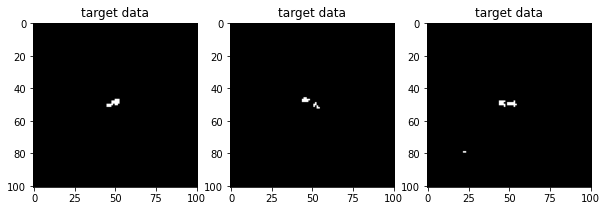

In [43]:
# visualize target samples
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3, figsize=(10, 10)) 

axarr[0].imshow(detedt_cfar[1200,:,:], cmap="gray") 
axarr[0].set_title('target data')
axarr[1].imshow(detedt_cfar[14,:,:], cmap="gray") 
axarr[1].set_title('target data')
axarr[2].imshow(detedt_cfar[43,:,:], cmap="gray") 
axarr[2].set_title('target data')

### Visualize the classification outputs 
Let's plot some images to compare the `actual data vs predicted data`, and `actual labels vs predicted labels`. One should keep in mind that the images undergone to size transformation.

### Draw bound boxes 
The bboxes are created based on binary classification and it will fail if we try to apply on another type of images. Also one should ensure that inputs are 2d_arrays. If we pass also predicted data values of an image, the function returns bbox around the data values while vizualizing also the prediction labels on another image. However, it will still calculate the bbox parameters from label image.

<Figure size 432x288 with 0 Axes>

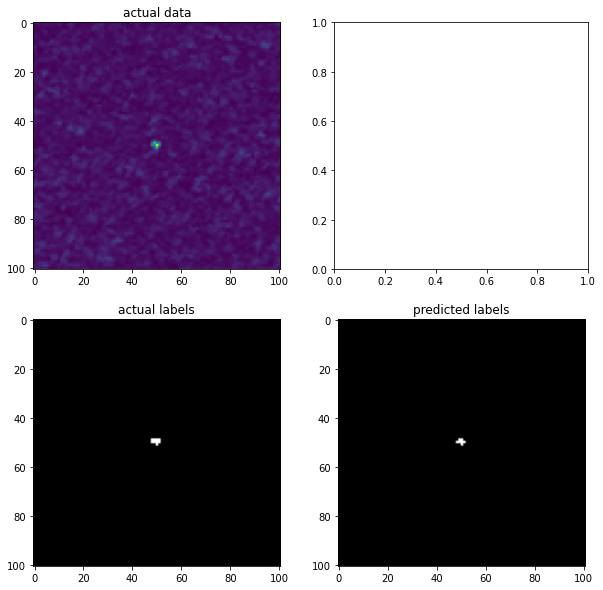

In [54]:
# define functions for vizualization 
def multiple_im_plot(no_image):
    
    plt.figure()

    #subplot(r,c) provide the no. of rows and columns
    f, axarr = plt.subplots(2,2, figsize=(10, 10)) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    axarr[0,0].imshow(data[no_image])
    axarr[0,0].set_title('actual data')
    axarr[1,0].imshow(target[no_image], cmap="gray")
    axarr[1,0].set_title('actual labels')
    axarr[1,1].imshow(detedt_cfar[no_image], cmap="gray") 
    axarr[1,1].set_title('predicted labels')
    
# visualize prediction examples 
multiple_im_plot(67)   

<Figure size 432x288 with 0 Axes>

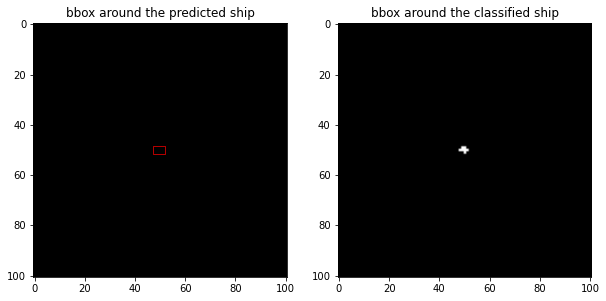

In [69]:
# vizualiza predicted ships with bbox
bbox_draw(detedt_cfar[67], dsize)

<Figure size 432x288 with 0 Axes>

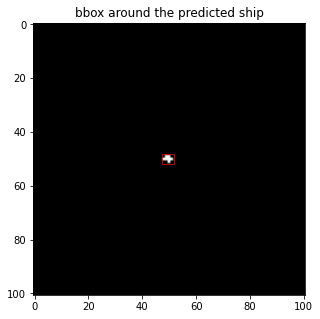

In [72]:
indx = np.argwhere(detedt_cfar[67]==1)
up_b    = indx[:,0].min()
down_b  = indx[:,0].max()
left_b  = indx[:,1].min()
right_b = indx[:,1].max()

# set up the bbox corners coordinate with 1 pixel out
upper_left = (left_b-0.75,up_b-0.75)
width = right_b-left_b+1.5
height = down_b-up_b+1.5

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, ax = plt.subplots(1, figsize=(5,5)) 
ax.imshow((detedt_cfar[67]).astype('float32'),cmap="gray")
ax.set_title('bbox around the predicted ship')

# Create a Rectangle patch
#Rectangle((left,upper),width,height))
rect = patches.Rectangle(
    upper_left,
    width,height,
    linewidth=0.7,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()